# Creating Faster Kernel Functions
by doing multiple time steps in one kernel and using shared memory.
Shared memory is block-specific, so regions will have to be halo'd per block.
Making the block do as many cells as possible means less waste to halos.
One thread could do multiple cells/edges.
If the edges a thread does belong to the cell it does, it doesn't have to write back to memory to do both a norm vel + ssh tendency calculation and update.
If it does multiple cells, if those cells are neighbors, it could be possible to do both tendency calculations and updates, and then another tendency calculation.

In [1]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_init/mode_init.jl")
include(CODE_ROOT * "visualization.jl")
include(CODE_ROOT * "mode_forward/time_steppers.jl")

forward_euler_step_cuda! (generic function with 1 method)

In [2]:
import CUDA

# Load Mesh From File

In [3]:
mpasOcean = MPAS_Ocean(false, CODE_ROOT * "MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic",
                "base_mesh.nc", "mesh.nc", periodicity="Periodic"
)
typeof(mpasOcean)

MPAS_Ocean

# Define Initial Condition

In [1]:
include(CODE_ROOT * "mode_init/initial_conditions.jl")

LoadError: UndefVarError: CODE_ROOT not defined

In [6]:
moveArrays!(mpasOcean, Array)

planeWaveInit!(mpasOcean) # could also do gaussianInit!

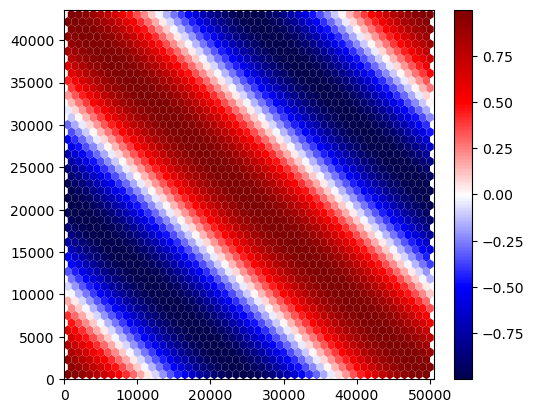

In [7]:
fig, ax, cbar, col = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

# Multi-timestep in one kernel with shared mem

In [101]:
function multi_fb_step_type_size_wrapper(
                                        normalVelocityTendencyT,
                                        normalVelocityT,
                                        sshTendencyT,
                                        sshT,
                                        cellsOnEdgeT,
                                        nEdgesOnEdgeT,
                                        edgesOnEdgeT,
                                        weightsOnEdgeT,
                                        nEdgesOnCellT,
                                        edgesOnCellT,
                                        cellsOnCellT,
                                        fEdgeT,
                                        bottomDepthT,
                                        dcEdgeT,
                                        dvEdgeT,
                                        areaCellT,
                                        edgeSignOnCellT,
                                    
                                        normalVelocityTendencySize,
                                        normalVelocitySize,
                                        sshTendencySize,
                                        sshSize,
                                        cellsOnEdgeSize,
                                        nEdgesOnEdgeSize,
                                        edgesOnEdgeSize,
                                        weightsOnEdgeSize,
                                        nEdgesOnCellSize,
                                        edgesOnCellSize,
                                        cellsOnCellSize,
                                        fEdgeSize,
                                        bottomDepthSize,
                                        dcEdgeSize,
                                        dvEdgeSize,
                                        areaCellSize,
                                        edgeSignOnCellSize,
                                    )
    # compiles the type and size of each array into the kernel definition
    return function multi_fb_step_kernel!(nSteps, dt, nEdges, nCells, gravity,

                                            normalVelocityTendencyG,
                                            normalVelocityG,
                                            sshTendencyG,
                                            sshG,
                                            cellsOnEdgeG,
                                            nEdgesOnEdgeG,
                                            edgesOnEdgeG,
                                            weightsOnEdgeG,
                                            nEdgesOnCellG,
                                            edgesOnCellG,
                                            cellsOnCellG,
                                            fEdgeG,
                                            bottomDepthG,
                                            dcEdgeG,
                                            dvEdgeG,
                                            areaCellG,
                                            edgeSignOnCellG)

        # allocate shared mem
        normalVelocityTendency = CUDA.@cuStaticSharedMem(Float32,   1024)
        normalVelocity         = CUDA.@cuStaticSharedMem(Float32,   1024)
        nEdgesOnEdge           = CUDA.@cuStaticSharedMem(Int32,     1024)
        fEdge                  = CUDA.@cuStaticSharedMem(Float32,   1024)
        dvEdge                 = CUDA.@cuStaticSharedMem(Float32,   1024)
        dcEdge                 = CUDA.@cuStaticSharedMem(Float32,   1024)
        
        sshTendency            = CUDA.@cuStaticSharedMem(Float32,   1024)
        ssh                    = CUDA.@cuStaticSharedMem(Float32,   1024)
        nEdgesOnCell           = CUDA.@cuStaticSharedMem(Int32,     1024)
        bottomDepth            = CUDA.@cuStaticSharedMem(Float32,   1024)
        areaCell               = CUDA.@cuStaticSharedMem(Float32,   1024)
        
        
        edgesOnCell            = CUDA.@cuStaticSharedMem(Int32,     1024)
        edgeSignOnCell         = CUDA.@cuStaticSharedMem(Int8,      1024)
        cellsOnCell            = CUDA.@cuStaticSharedMem(Int32,     1024)
        
        edgesOnEdge            = CUDA.@cuStaticSharedMem(Int32,     1024)
        weightsOnEdge          = CUDA.@cuStaticSharedMem(Float32,   1024)
        
        
        cellsOnEdge            = CUDA.@cuStaticSharedMem(Int32,     1024)
        
#         normalVelocityTendency
#         normalVelocity
#         sshTendency
#         ssh
#         cellsOnEdge
#         nEdgesOnEdge
#         edgesOnEdge
#         weightsOnEdge
#         nEdgesOnCell
#         edgesOnCell
#         cellsOnCell
#         fEdge
#         bottomDepth
#         dcEdge
#         dvEdge
#         areaCell
#         edgeSignOnCell
        
        
        # move data to shared mem
        normalVelocityTendency[CUDA.threadIdx().x] = normalVelocityTendencyG[CUDA.threadIdx().x]
        normalVelocity[CUDA.threadIdx().x]         = normalVelocityG[CUDA.threadIdx().x]
        sshTendency[CUDA.threadIdx().x]            = sshTendencyG[CUDA.threadIdx().x]
        ssh[CUDA.threadIdx().x]                    = sshG[CUDA.threadIdx().x]
        cellsOnEdge[CUDA.threadIdx().x]            = cellsOnEdgeG[CUDA.threadIdx().x]
        nEdgesOnEdge[CUDA.threadIdx().x]           = nEdgesOnEdgeG[CUDA.threadIdx().x]
        edgesOnEdge[CUDA.threadIdx().x]            = edgesOnEdgeG[CUDA.threadIdx().x]
        weightsOnEdge[CUDA.threadIdx().x]          = weightsOnEdgeG[CUDA.threadIdx().x]
        nEdgesOnCell[CUDA.threadIdx().x]           = nEdgesOnCellG[CUDA.threadIdx().x]
        edgesOnCell[CUDA.threadIdx().x]            = edgesOnCellG[CUDA.threadIdx().x]
        cellsOnCell[CUDA.threadIdx().x]            = cellsOnCellG[CUDA.threadIdx().x]
        fEdge[CUDA.threadIdx().x]                  = fEdgeG[CUDA.threadIdx().x]
        bottomDepth[CUDA.threadIdx().x]            = bottomDepthG[CUDA.threadIdx().x]
        dcEdge[CUDA.threadIdx().x]                 = dcEdgeG[CUDA.threadIdx().x]
        dvEdge[CUDA.threadIdx().x]                 = dvEdgeG[CUDA.threadIdx().x]
        areaCell[CUDA.threadIdx().x]               = areaCellG[CUDA.threadIdx().x]
        edgeSignOnCell[CUDA.threadIdx().x]         = edgeSignOnCellG[CUDA.threadIdx().x]

        
        # perform time steps
#         for i in 1:nSteps
    #         calculate_normal_velocity_tendency_cuda_kernel!(nEdges, normalVelocityTendency, normalVelocity, ssh, cellsOnEdge, nEdgesOnEdge, edgesOnEdge, weightsOnEdge, fEdge, dcEdge, gravity)

    #         update_normal_velocity_by_tendency_cuda_kernel!(nEdges, normalVelocity, dt, normalVelocityTendency)

    #         calculate_ssh_tendency_cuda_kernel!(nCells, sshTendency, ssh, normalVelocity, bottomDepth, nEdgesOnCell, edgesOnCell, cellsOnCell, areaCell, edgeSignOnCell, dvEdge)

    #         update_ssh_by_tendency_cuda_kernel!(nCells, ssh, dt, sshTendency)
#         end

        # move data back
#         CUDA.@cushow typeof(normalVelocityG)
#         CUDA.@cushow typeof(normalVelocityTendency)
        normalVelocityTendencyG[CUDA.threadIdx().x] = normalVelocityTendency[CUDA.threadIdx().x]
        normalVelocityG[CUDA.threadIdx().x]         = normalVelocity[CUDA.threadIdx().x]
        sshTendencyG[CUDA.threadIdx().x]            = sshTendency[CUDA.threadIdx().x]
        sshG[CUDA.threadIdx().x]                    = ssh[CUDA.threadIdx().x]
        cellsOnEdgeG[CUDA.threadIdx().x]            = cellsOnEdge[CUDA.threadIdx().x]
        nEdgesOnEdgeG[CUDA.threadIdx().x]           = nEdgesOnEdge[CUDA.threadIdx().x]
        edgesOnEdgeG[CUDA.threadIdx().x]            = edgesOnEdge[CUDA.threadIdx().x]
        weightsOnEdgeG[CUDA.threadIdx().x]          = weightsOnEdge[CUDA.threadIdx().x]
        nEdgesOnCellG[CUDA.threadIdx().x]           = nEdgesOnCell[CUDA.threadIdx().x]
        edgesOnCellG[CUDA.threadIdx().x]            = edgesOnCell[CUDA.threadIdx().x]
        cellsOnCellG[CUDA.threadIdx().x]            = cellsOnCell[CUDA.threadIdx().x]
        fEdgeG[CUDA.threadIdx().x]                  = fEdge[CUDA.threadIdx().x]
        bottomDepthG[CUDA.threadIdx().x]            = bottomDepth[CUDA.threadIdx().x]
        dcEdgeG[CUDA.threadIdx().x]                 = dcEdge[CUDA.threadIdx().x]
        dvEdgeG[CUDA.threadIdx().x]                 = dvEdge[CUDA.threadIdx().x]
        areaCellG[CUDA.threadIdx().x]               = areaCell[CUDA.threadIdx().x]
        edgeSignOnCellG[CUDA.threadIdx().x]         = edgeSignOnCell[CUDA.threadIdx().x]

        return
    end
end

multi_fb_step_type_size_wrapper (generic function with 1 method)

In [ ]:
# eltype(normalVelocityTendencyG)
# eltype(normalVelocityG        )
# eltype(sshTendencyG           )
# eltype(sshG                   )
# eltype(cellsOnEdgeG           )
# eltype(nEdgesOnEdgeG          )
# eltype(edgesOnEdgeG           )
# eltype(weightsOnEdgeG         )
# eltype(nEdgesOnCellG          )
# eltype(edgesOnCellG           )
# eltype(cellsOnCellG           )
# eltype(fEdgeG                 )
# eltype(bottomDepthG           )
# eltype(dcEdgeG                )
# eltype(dvEdgeG                )
# eltype(areaCellG              )
# eltype(edgeSignOnCellG        )

In [53]:
println(eltype(mpasOcean.normalVelocityTendency))
println(eltype(mpasOcean.normalVelocityCurrent ))
println(eltype(mpasOcean.sshTendency           ))
println(eltype(mpasOcean.sshCurrent            ))
println(eltype(mpasOcean.cellsOnEdge           ))
println(eltype(mpasOcean.nEdgesOnEdge          ))
println(eltype(mpasOcean.edgesOnEdge           ))
println(eltype(mpasOcean.weightsOnEdge         ))
println(eltype(mpasOcean.nEdgesOnCell          ))
println(eltype(mpasOcean.edgesOnCell           ))
println(eltype(mpasOcean.cellsOnCell           ))
println(eltype(mpasOcean.fEdge                 ))
println(eltype(mpasOcean.bottomDepth           ))
println(eltype(mpasOcean.dcEdge                ))
println(eltype(mpasOcean.dvEdge                ))
println(eltype(mpasOcean.areaCell              ))
println(eltype(mpasOcean.edgeSignOnCell        ))

Float64
Float64
Float64
Float64
Int32
Int32
Int32
Float64
Int32
Int32
Int32
Float64
Float64
Float64
Float64
Float64
Int8


In [102]:
multi_fb_step_kernel! = multi_fb_step_type_size_wrapper(
        eltype(mpasOcean.normalVelocityTendency),
        eltype(mpasOcean.normalVelocityCurrent),
        eltype(mpasOcean.sshTendency),
        eltype(mpasOcean.sshCurrent),
        eltype(mpasOcean.cellsOnEdge),
        eltype(mpasOcean.nEdgesOnEdge),
        eltype(mpasOcean.edgesOnEdge),
        eltype(mpasOcean.weightsOnEdge),
        eltype(mpasOcean.nEdgesOnCell),
        eltype(mpasOcean.edgesOnCell),
        eltype(mpasOcean.cellsOnCell),
        eltype(mpasOcean.fEdge),
        eltype(mpasOcean.bottomDepth),
        eltype(mpasOcean.dcEdge),
        eltype(mpasOcean.dvEdge),
        eltype(mpasOcean.areaCell),
        eltype(mpasOcean.edgeSignOnCell),

        size(mpasOcean.normalVelocityTendency),
        size(mpasOcean.normalVelocityCurrent),
        size(mpasOcean.sshTendency),
        size(mpasOcean.sshCurrent),
        size(mpasOcean.cellsOnEdge),
        size(mpasOcean.nEdgesOnEdge),
        size(mpasOcean.edgesOnEdge),
        size(mpasOcean.weightsOnEdge),
        size(mpasOcean.nEdgesOnCell),
        size(mpasOcean.edgesOnCell),
        size(mpasOcean.cellsOnCell),
        size(mpasOcean.fEdge),
        size(mpasOcean.bottomDepth),
        size(mpasOcean.dcEdge),
        size(mpasOcean.dvEdge),
        size(mpasOcean.areaCell),
        size(mpasOcean.edgeSignOnCell),
    )

multi_fb_step_kernel! (generic function with 1 method)

In [26]:
moveArrays!(mpasOcean, CUDA.CuArray)

In [103]:
# CUDA.@device_code_warntype
CUDA.@cuda blocks=1 threads=1024 multi_fb_step_kernel!(25,
                                                        mpasOcean.dt,
                                                        mpasOcean.nEdges, mpasOcean.nCells,
                                                        mpasOcean.gravity,
        
                                                        mpasOcean.normalVelocityTendency,
                                                        mpasOcean.normalVelocityCurrent,
                                                        mpasOcean.sshTendency,
                                                        mpasOcean.sshCurrent,
                                                        mpasOcean.cellsOnEdge,
                                                        mpasOcean.nEdgesOnEdge,
                                                        mpasOcean.edgesOnEdge,
                                                        mpasOcean.weightsOnEdge,
                                                        mpasOcean.nEdgesOnCell,
                                                        mpasOcean.edgesOnCell,
                                                        mpasOcean.cellsOnCell,
                                                        mpasOcean.fEdge,
                                                        mpasOcean.bottomDepth,
                                                        mpasOcean.dcEdge,
                                                        mpasOcean.dvEdge,
                                                        mpasOcean.areaCell,
                                                        mpasOcean.edgeSignOnCell)

LoadError: Failed to compile PTX code (ptxas exited with code 255)
ptxas error   : Entry function '_Z33julia_multi_fb_step_kernel__167375Int647Float64S_S_S0_13CuDeviceArrayIS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_I5Int32Li2ELi1EES1_IS2_Li1ELi1EES1_IS2_Li2ELi1EES1_IS0_Li2ELi1EES1_IS2_Li1ELi1EES1_IS2_Li2ELi1EES1_IS2_Li2ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_I4Int8Li2ELi1EE' uses too much shared data (0x10400 bytes, 0xc000 max)
ptxas info    : 272 bytes gmem
ptxas info    : Compiling entry function '_Z33julia_multi_fb_step_kernel__167375Int647Float64S_S_S0_13CuDeviceArrayIS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_I5Int32Li2ELi1EES1_IS2_Li1ELi1EES1_IS2_Li2ELi1EES1_IS0_Li2ELi1EES1_IS2_Li1ELi1EES1_IS2_Li2ELi1EES1_IS2_Li2ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_I4Int8Li2ELi1EE' for 'sm_61'
ptxas info    : Function properties for _Z33julia_multi_fb_step_kernel__167375Int647Float64S_S_S0_13CuDeviceArrayIS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_I5Int32Li2ELi1EES1_IS2_Li1ELi1EES1_IS2_Li2ELi1EES1_IS0_Li2ELi1EES1_IS2_Li1ELi1EES1_IS2_Li2ELi1EES1_IS2_Li2ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_IS0_Li1ELi1EES1_I4Int8Li2ELi1EE
    8 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 118 registers, 66560 bytes smem, 816 bytes cmem[0]
ptxas info    : Function properties for gpu_report_exception
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Function properties for gpu_signal_exception
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Function properties for julia_throw_boundserror_17096
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Function properties for julia_throw_boundserror_17102
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Function properties for julia_throw_boundserror_17108
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Function properties for julia_throw_boundserror_17111
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Function properties for julia_throw_boundserror_17114
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
If you think this is a bug, please file an issue and attach /tmp/jl_d7vsYN.ptx